In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
#%matplotlib nbagg
%matplotlib notebook

In [2]:
#!pip install --upgrade scipy

# The N-body problem

The N-body problem is a physics problem concerning the movement of N bodys interacting gravitationally with each other. Solving this problem consist in solving the following set of differential equations:

\begin{equation}
    m_i \frac{d^2\vec r_i}{dt^2} = \sum_{j=1\\j\neq i}^N \frac{Gm_im_j(\vec r_j-\vec r_i)}{|\vec r_j-\vec r_i|^3}
\end{equation}

simplifying:
\begin{equation}
    \frac{d^2\vec r_i}{dt^2} = \sum_{j=1\\j\neq i}^N \frac{Gm_j(\vec r_j-\vec r_i)}{|\vec r_j-\vec r_i|^3}
\end{equation}

which is a second order ODE. 

In [3]:
def n_body_diff_eqs(t, r, ms, G=1):
    """
    Returns the differential equations to solve
    t: array-like
        Time interval to obtain the solution of the 
        differential equation.
        
    r: array-like
        Initial conditions of the differential equations.
        The length must be 6*N since for each body there
        must be 3 initial conditions for the position (x,
        y, z) and 3 for the velocity (vx, vy, vz).
        Then, r has the following structure r = [x1, y1,
        z1, vx1, vx2, vx3, x2, y2, z2, vx2, vy2, vz2,...]. 
        
    ms: array-like
        Array of length N containing the masses of the N
        bodies.
        
    G: float
        Universal gravitational constant. Default value is
        set to 1 due to the use of the canonical units. 
    """
    
    #Number of bodies. 
    n = 6
    N = int(len(r)/n)
    
    #Equations
    ecs = np.zeros(len(r))
    
    for i in range(N):
        dvdt_i = [0, 0, 0]
        
        for j in range(N):
            if i != j:
                d = np.sqrt((r[6*j+0]-r[6*i+0])**2 +
                            (r[6*j+1]-r[6*i+1])**2 +
                            (r[6*j+2]-r[6*i+2])**2 )
        
                for k in range(3):
                    #Acceleration dv/dt
                    dvdt_i[k] += G*ms[j]*( r[6*j+k] - r[6*i+k] ) / d**3
                    
        for l in range(3):
            ecs[6*i + l] = r[6*i + 3 + l]
            ecs[6*i + 3 + l] = dvdt_i[l] 
            
    return ecs


def plot_n_body_sol(sol, labels=False, draw_path=True, draw_init=True, draw_end=False, figsize=(9,9)):
    """
    Plots the solution of the N-body problem.
    sol: array-like
        Array of shape (len(ts), 6*N) containing the so-
        lution of the N-body problem.
        
    labels: bool/array-like
        If type is array-like then the array must content
        the names of the N bodies for which the problem 
        was solved.
    
    draw_path: bool
        Draw the path that each particule follows in the 
        time.
    
    draw_init: bool
        Draw the initial position of the N particles.
        
    draw_end: bool
        Draw the last position of the particule in the time
        of the simulation.
        
    figsize: tuple
        tuple containing the dimensions of the plot.
    """
    #Number of bodies
    N = int(sol.shape[1]/6)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection="3d")
    font_label = {
            'family': 'serif',
            'weight': 'normal',
            'size': 8}
    
    font_label2 = {
            'family': 'serif',
            'weight': 'normal',
            'size': 10}
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    if np.array(labels).any:
        for i in range(N):
            if draw_path: ax.plot(sol.T[6*i+0],        sol.T[6*i+1],     sol.T[6*i+2],    c=colors[i])
            if draw_end:  ax.scatter(sol.T[6*i+0][-1], sol.T[6*i+1][-1], sol.T[6*i+2][-1],c=colors[i], marker="o")
            if draw_init: ax.scatter(sol.T[6*i+0][0],  sol.T[6*i+1][0],  sol.T[6*i+2][0], c=colors[i], 
                                     label=labels[i], marker="o")

        plt.legend(loc="lower center", ncol=len(labels),
                   fancybox=True, shadow=True,
                   mode="expand",prop=font_label)

    else:
        for i in range(N):
            ax.plot(sol.T[6*i+0], sol.T[6*i+1], sol.T[6*i+2])
            ax.scatter(sol.T[6*i+0][0], sol.T[6*i+1][0], sol.T[6*i+2][0], "o")
    
    ax.set_xlabel("X [AU]", fontdict=font_label2)
    ax.set_ylabel("Y [AU]", fontdict=font_label2)
    ax.set_zlabel("Z [AU]", fontdict=font_label2)
    ax.set_zlim(ax.get_xlim())
    plt.tight_layout()
    

def vs_polygon(N, l, c=(0,0), rot=True):
    """
    Returns the vertices of a regular polygon.
    N: int
        Sides of the polygon.
    l: float
        Distance from the center of the polygon to any vertex.
    c: list/tuple
        The center of the polygon.
    rot: bool
        If true then rotates the points of the polygon such that
        a vertex is in the top of the plot. Default True.
    """
    
    vs    = [[c[0] + l*np.cos(2*np.pi*(i/N)), c[1] + l*np.sin(2*np.pi*(i/N))] for i in range(N)] 
    if rot:
        theta = -(90 - 360/N) * (np.pi/180)
        Rot   = np.array([ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)] ])
        vs_r  = np.array(vs).dot(Rot)
        return [list(v) for v in vs_r]
    
    return vs

# N-body simulation for the Solar System

In astronomy, the magnitudes use to be so large that  we can not compare them easily. Due to this, it is common to rewrite the values using scales that allow us to compare easily. For this example, canonical units are chosen. The unit of mass is the mass of the Sun, and we set $G=1$. 

In [4]:
#Canonical units
m  = 1
km = 1000*m
kg = 1
s  = 1
G  = 6.67408e-11*m**3/kg/s**2

ul = 1.496e11*m
um = 1.9891e30*kg
ut = np.sqrt(ul**3/(G*um))
G  = 1

In [5]:
#Load the initial conditions for the Solar System. (https://ssd.jpl.nasa.gov/horizons/app.html#/)
data = pd.read_csv("./initial_conditions_solar_system.csv")
data.columns = data.columns.str.strip()

#Converting the units from km, kg and sec to ul, um and ut
data[["X", "Y", "Z"]] = data[["X", "Y", "Z"]]*km/ul
data[["VX", "VY", "VZ"]] = data[["VX", "VY", "VZ"]]*km*ut/ul
data[["Mass"]] = data[["Mass"]]/um

#visualize data
data

,Body,Mass,JDTDB,Calendar Date (TDB),X,Y,Z,VX,VY,VZ
0,Sun,1.000000e+00,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,-0.008663,-0.001562,0.000215,0.000176,-0.000481,3.862460e-08
1,Mercury,1.660148e-07,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,-0.339949,0.129989,0.041352,-0.940673,-1.450777,-3.221998e-02
2,Venus,2.447589e-06,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,-0.023965,-0.728248,-0.008879,1.167661,-0.029604,-6.776667e-02
3,Earth,3.003167e-06,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,0.324111,-0.962164,0.000263,0.929066,0.322754,-5.768790e-05
4,Mars,3.226836e-07,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,-1.657854,0.154525,0.043940,-0.046112,-0.740797,-1.438007e-02
5,Jupiter,9.545020e-04,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,4.295264,2.460586,-0.106305,-0.222914,0.401238,3.321729e-03
6,Saturn,2.857875e-04,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,8.630429,-4.589742,-0.263813,0.134168,0.285672,-1.031256e-02
7,Uranus,4.364788e-05,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,12.791430,14.894383,-0.110397,-0.175103,0.138290,2.778441e-03
8,Neptune,5.148057e-05,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,29.800637,-2.338763,-0.638623,0.013087,0.182988,-4.077958e-03
9,Pluto,7.395304e-09,2460137.5,A.D. 2023-Jul-12 00:00:00.0000,16.713506,-30.486667,-1.572293,0.164311,0.047213,-5.315728e-02


In [6]:
#Building the state vector for the bodies in the Solar System (not includding Pluto)
SV_solSystem = list(data.values[:,4:10][0:9].flatten())
ms_solSystem = list(data["Mass"].values[0:9])

#To see the full trayectory of every planet we solve the n-body problem
#from zero ut to the orbital period (in ut's) of the outter planet, here
#Neptune, its orbital period is 165 years.
t_max = 165*365*24*3600/ut
ts_solSystem = np.linspace(0,t_max,10000)

In [7]:
#solving the n-body problem for the Solar System
sol_solSystem = odeint(n_body_diff_eqs, y0=SV_solSystem, t=ts_solSystem, args=(ms_solSystem,), tfirst=True)

<IPython.core.display.Javascript object>


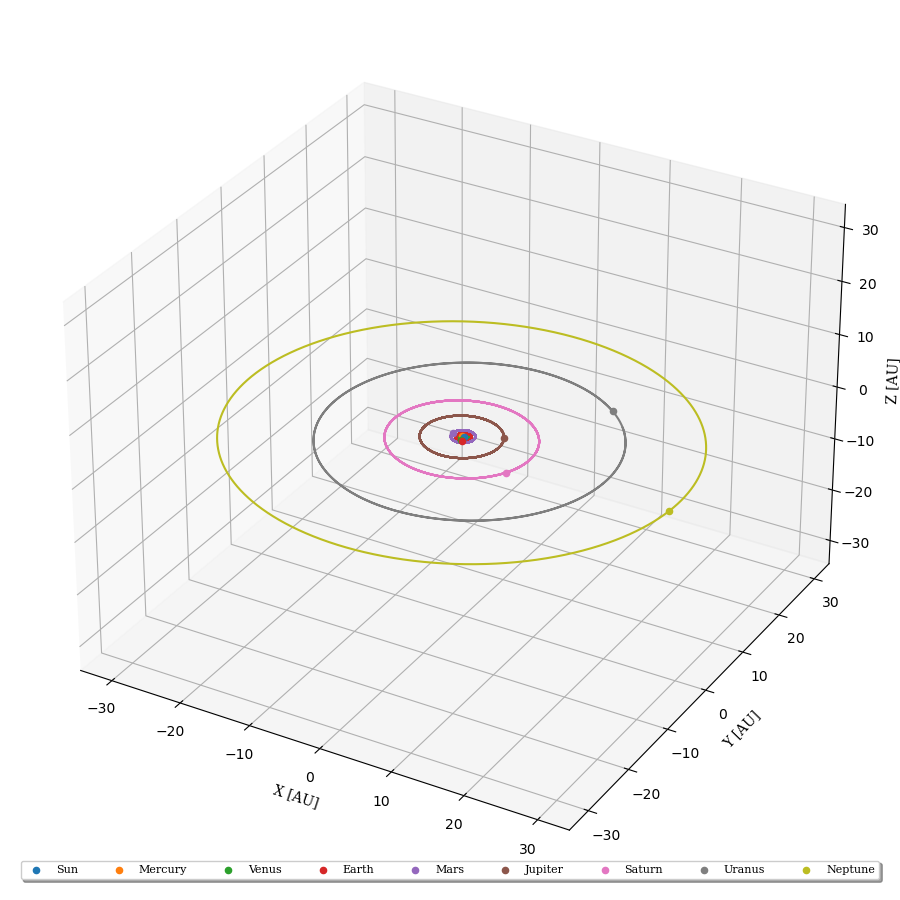

In [10]:
plot_n_body_sol(sol=sol_solSystem, labels=data.Body.values)

And now, what would happen if we just change the mass of a planet, lets say, Jupiter. Lets see what happen with the solar system when we increase the mass of Jupiter to $10M_J$, $100M_J$, $500M_J$ (this last case implies a mass almost a half of the solar mass).

#### $10M_J$ 

In [27]:
ms_solSystem_10j = ms_solSystem.copy()
ms_solSystem_10j[5] = 10*ms_solSystem_10j[5]

In [31]:
#solving the n-body problem for the Solar System with 10M_j
sol_solSystem_10j = odeint(n_body_diff_eqs, y0=SV_solSystem, t=ts_solSystem, args=(ms_solSystem_10j,), tfirst=True)

<IPython.core.display.Javascript object>


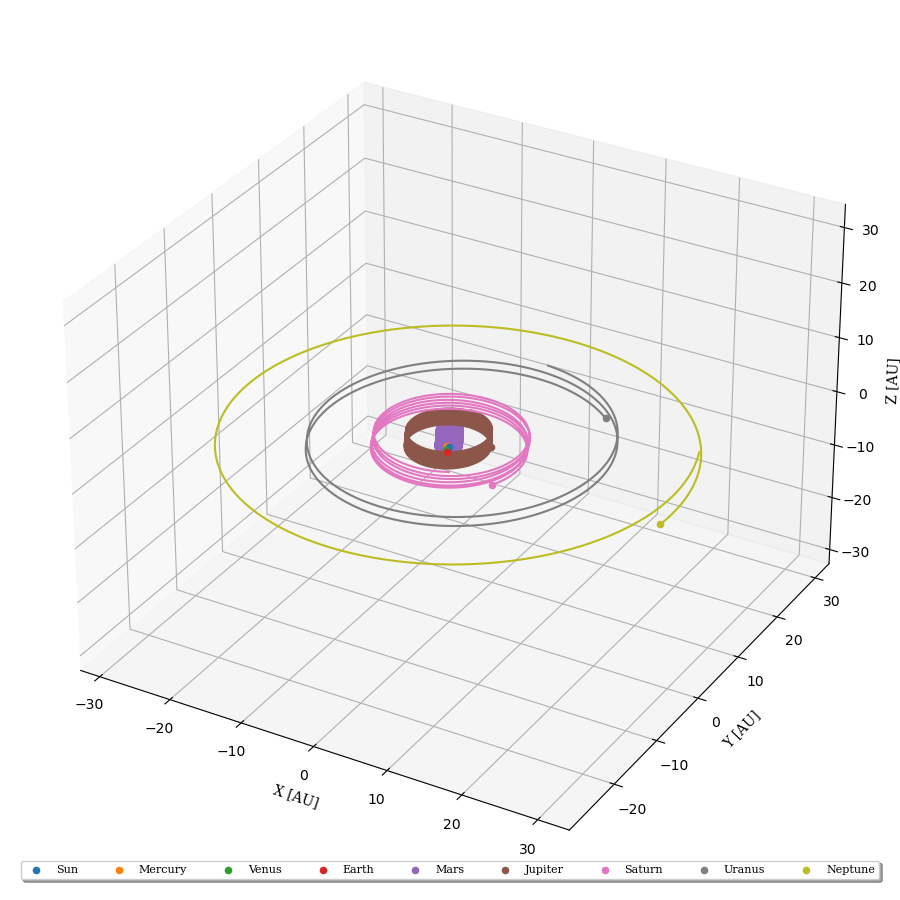

In [32]:
plot_n_body_sol(sol=sol_solSystem_10j, labels=data.Body.values)

#### $100M_J$ 

In [35]:
ms_solSystem_100j = ms_solSystem.copy()
ms_solSystem_100j[5] = 100*ms_solSystem_100j[5]

In [37]:
#solving the n-body problem for the Solar System with 100Mj
sol_solSystem_100j = odeint(n_body_diff_eqs, y0=SV_solSystem, t=ts_solSystem, args=(ms_solSystem_100j,), tfirst=True)

<IPython.core.display.Javascript object>


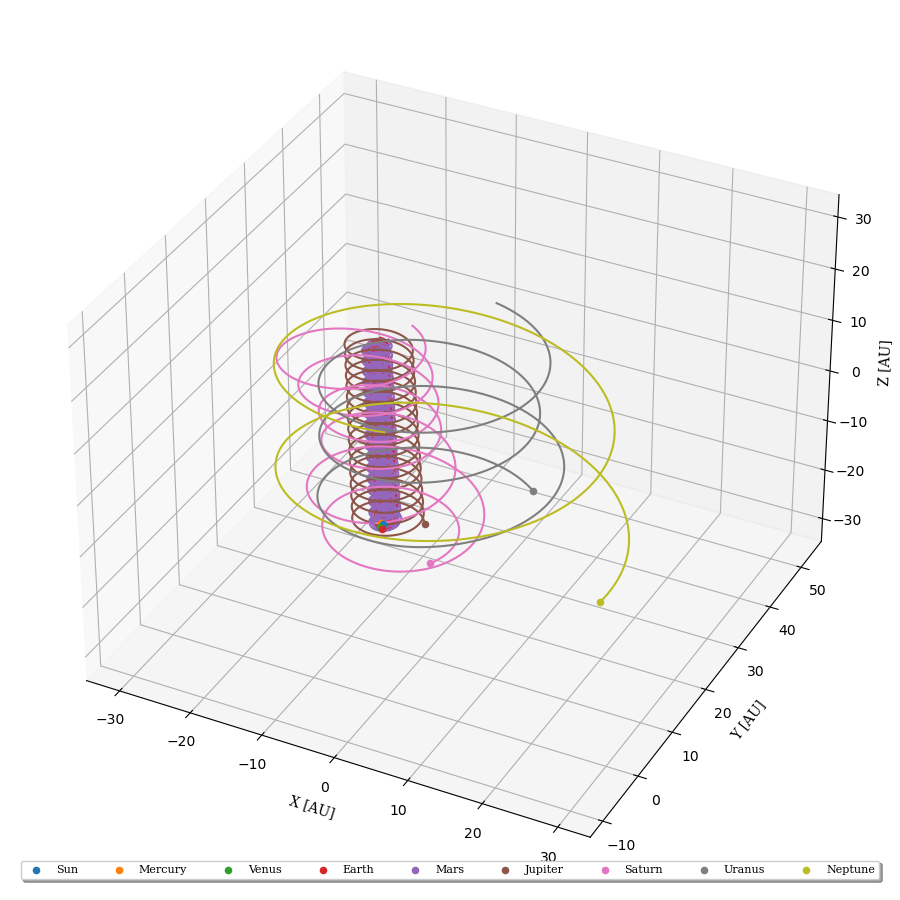

In [38]:
plot_n_body_sol(sol=sol_solSystem_100j, labels=data.Body.values)

#### $500M_J$ 

In [44]:
ms_solSystem_1000j = ms_solSystem.copy()
ms_solSystem_1000j[5] = 500*ms_solSystem_1000j[5]

In [45]:
#solving the n-body problem for the Solar System with 100Mj
sol_solSystem_500j = odeint(n_body_diff_eqs, y0=SV_solSystem, t=ts_solSystem, args=(ms_solSystem_500j,), tfirst=True)

<IPython.core.display.Javascript object>


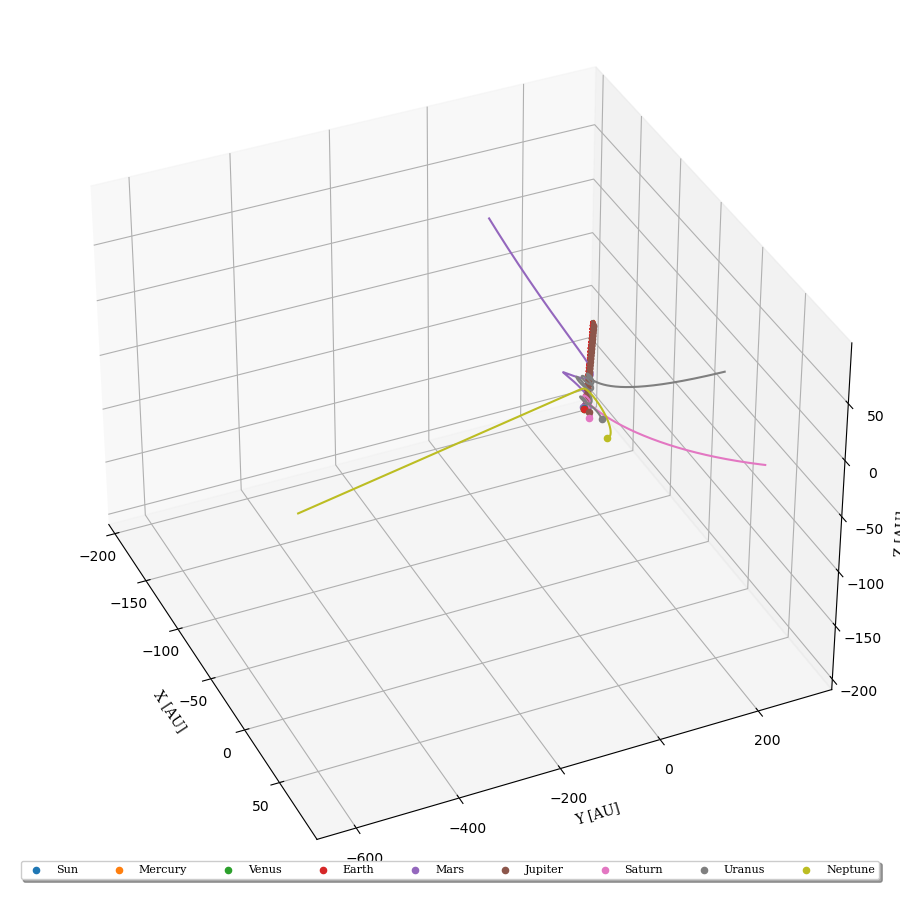

In [46]:
plot_n_body_sol(sol=sol_solSystem_500j, labels=data.Body.values)

# Some 3-body dances (Animation)

In [28]:
#If we just change a little bit the initial conditions of this system then
#its dynamic will change drastically, this is a chaotic system.
sv_1  = [-1,0,0,0,0,-0.01]
sv_2  = [2,2,0,0,2.2,0.01]
sv_3  = [4,0,0,0,3.75133030951881,0.2]
sv_3b = sv_1 + sv_2 + sv_3

ms_3b = [10, 5, 1]
ts_3b = np.linspace(0,500,30000)

In [29]:
sol_3 = odeint(n_body_diff_eqs, sv_3b, ts_3b, args=(ms_3b,), tfirst=True, )
#plot_n_body_sol(sol_3, labels=["m1", "m2", "m3"], draw_end=True, draw_init=True, draw_path=True )

<IPython.core.display.Javascript object>


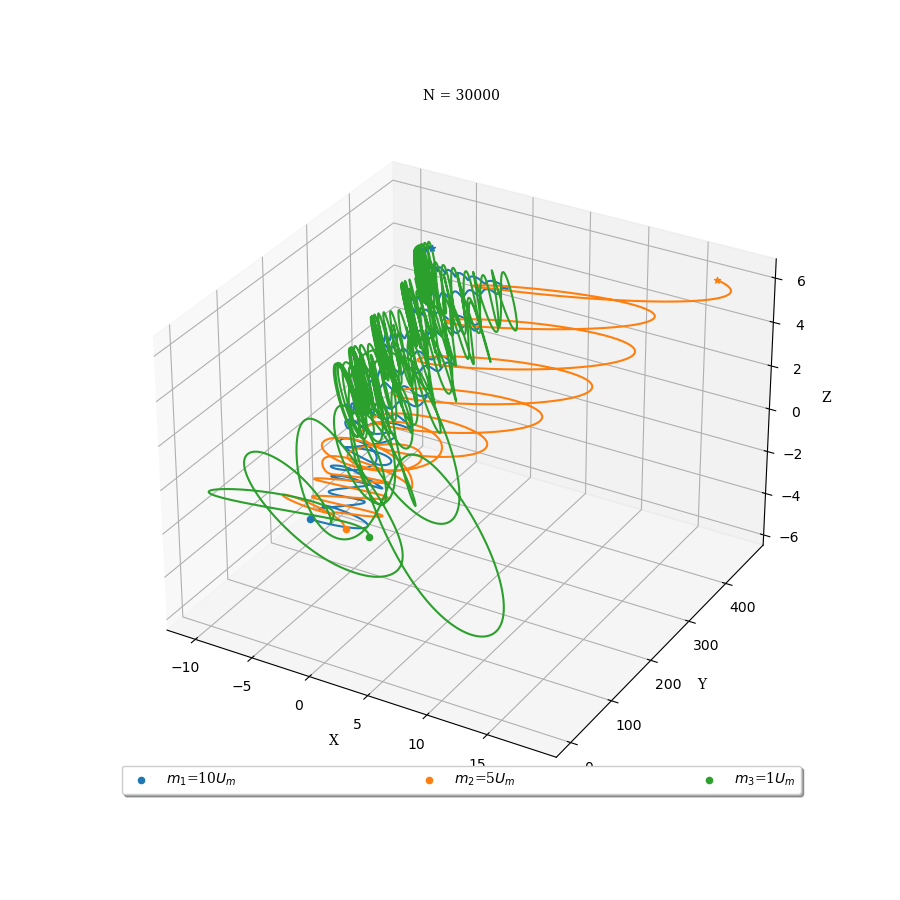

In [34]:
step = 10
idx  = step
frames = int(len(sol_3)/step)
N = int(sol_3.shape[1]/6)

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection="3d")
font_label = {
            'family': 'serif',
            'weight': 'normal',
            'size': 10}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

labels=["$m_1$", "$m_2$", "$m_3$"]
    
def init_function():pass
    
def draw(i):
    global idx
    plt.cla()
    for i in range(N):
        ax.plot(   sol_3.T[6*i+0][0:idx], sol_3.T[6*i+1][0:idx], sol_3.T[6*i+2][0:idx], color=colors[i])
        ax.scatter(sol_3.T[6*i+0][idx-1], sol_3.T[6*i+1][idx-1], sol_3.T[6*i+2][idx-1], color=colors[i], marker="*")
        ax.scatter(sol_3.T[6*i+0][0],   sol_3.T[6*i+1][0],   sol_3.T[6*i+2][0],   color=colors[i],
                   label=f"{labels[i]}={ms_3b[i]}$U_m$")
        ax.set_title(f"N = {idx}", fontdict=font_label)

    ax.set_xlabel("X", fontdict=font_label)
    ax.set_ylabel("Y", fontdict=font_label)
    ax.set_zlabel("Z", fontdict=font_label)
    
    plt.legend(loc="lower center", ncol=len(labels),
                   fancybox=True, shadow=True,
                   mode="expand",prop=font_label)
    
    idx+=step
        
animation = FuncAnimation(plt.gcf(), draw, frames, interval=15, repeat=False, init_func=init_function) 